In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Helper Methods

In [19]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()
    
    return plt

### Loading Data

In [20]:
df = pd.read_csv('../ready4Learning2.csv', index_col = 0)
df.drop(df.tail(1).index,inplace=True)
df['Age@Scan'] = df['Age@Scan'].astype('float64')

print(df.ConsensusDiagnosis.value_counts())

print("\nDataType")
print(df['Age@Scan'].dtypes)

0    482
1    261
Name: ConsensusDiagnosis, dtype: int64

DataType
float64


### Downsampling

In [21]:
# from sklearn.utils import resample

# df_majority = df[df.ConsensusDiagnosis==0]
# df_minority = df[df.ConsensusDiagnosis==1]

# df_majority_downsampled = resample(df_majority, 
#                                    replace=False,
#                                    n_samples=261,
#                                    random_state=123)

# df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# print(df_downsampled.ConsensusDiagnosis.value_counts())

# target = df_downsampled.ConsensusDiagnosis
# features = df_downsampled.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate'], axis = 1)

target = df.ConsensusDiagnosis
features = df.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate'], axis = 1)

In [22]:
features.head()

,Age@Scan,Intracranial_Volume,LEC_Volume,LEC_Thickness,REC_Volume,REC_Thickness,0,1,2,3,...,270,271,272,273,274,275,DAT,MCI,NCF,NCO
0,80.1,1.540673e+06,348.266601,1.937101,387.817382,2.086522,10892,8475,6917,6471,...,0,623,686,2330,257,292,0.0,0.0,0.0,1.0
1,51.8,1.808080e+06,478.344726,2.374539,404.736328,2.691179,12305,9670,9493,9876,...,13,201,255,2519,352,501,0.0,0.0,0.0,1.0
2,60.9,1.647645e+06,505.810546,2.471316,481.640625,2.168210,9364,9456,11038,9008,...,16,166,117,2321,465,605,0.0,0.0,1.0,0.0
3,65.9,1.946612e+06,623.364257,2.486266,536.352539,2.027633,12349,10002,10009,10551,...,0,503,343,4910,385,626,0.0,0.0,1.0,0.0
4,53.0,1.501198e+06,449.340820,2.376151,307.177734,2.099336,10347,8601,10127,8696,...,36,173,153,2623,458,458,0.0,0.0,1.0,0.0


### Standardizing and Splitting Data

In [23]:
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)

from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.3, random_state = 0)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### PCA (standardized)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95)

pca.fit(features_train)

features_train = pca.transform(features_train)
features_test = pca.transform(features_test)
features_val = pca.transform(features_val)

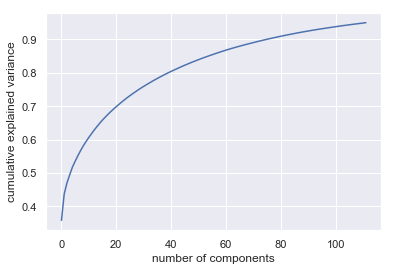

In [25]:
#pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

# best_logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=0.0001, max_iter=500, multi_class='warn',
#           n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
#           tol=0.0001, verbose=0, warm_start=False)

penalties = ['l1', 'l2']
tols = [1e-2, 1e-3, 1e-4]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 'intercept_scaling': intercepts}

gs_logit = GridSearchCV(logit, params_logit, cv=10)

gs_logit.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10], 'penalty': ['l1', 'l2'], 'tol': [0.01, 0.001, 0.0001], 'fit_intercept': [True, False], 'class_weight': [None, 'balanced'], 'intercept_scaling': [0.0001, 0.001, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.6832230839416058
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       137
           1       0.56      0.58      0.57        64

   micro avg       0.72      0.72      0.72       201
   macro avg       0.68      0.68      0.68       201
weighted avg       0.72      0.72      0.72       201



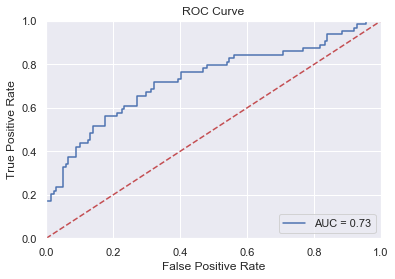

In [27]:
predictions = gs_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_logit, 'val')
savefig('../images/logit/pca_val.png')

Balanced_Accuracy: 0.7469604863221885
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        47
           1       0.72      0.64      0.68        28

   micro avg       0.77      0.77      0.77        75
   macro avg       0.76      0.75      0.75        75
weighted avg       0.77      0.77      0.77        75



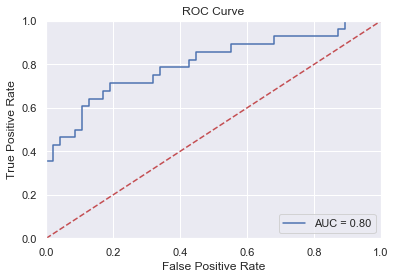

In [28]:
predictions = gs_logit.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_logit, 'test')
savefig('../images/logit/pca_test.png')

### LDA

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

solvers = ['lsqr']
shrinkages = [None, 'auto']
tols = [1e-3, 1e-4, 1e-5]
components = [0,1]

params_lda = {'solver': solvers,'shrinkage': shrinkages, 'tol': tols, 'n_components':components}

gs_lda = GridSearchCV(lda, params_lda, cv=10)
gs_lda.fit(features_train, target_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['lsqr'], 'shrinkage': [None, 'auto'], 'tol': [0.001, 0.0001, 1e-05], 'n_components': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.669194799270073
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       137
           1       0.61      0.48      0.54        64

   micro avg       0.74      0.74      0.74       201
   macro avg       0.69      0.67      0.68       201
weighted avg       0.73      0.74      0.73       201



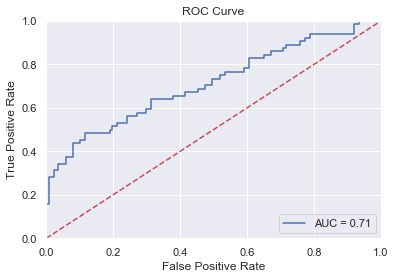

In [30]:
predictions = gs_lda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')
savefig('../images/lda/pca_val.png')

Balanced_Accuracy: 0.7610182370820668
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        47
           1       0.81      0.61      0.69        28

   micro avg       0.80      0.80      0.80        75
   macro avg       0.80      0.76      0.77        75
weighted avg       0.80      0.80      0.79        75



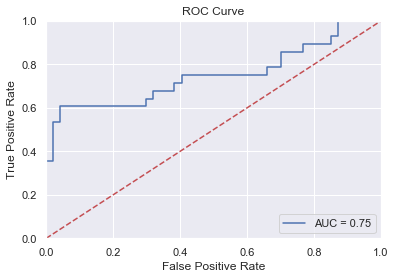

In [31]:
predictions = gs_lda.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_lda, 'test')
savefig('../images/lda/pca_test.png')

### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

neighbors = [1,3,5,7,9]
weights = ['uniform', 'distance']
algo = ['ball_tree', 'kd_tree', 'brute']

params_knn = {'n_neighbors': neighbors, 'weights': weights, 'algorithm': algo}
gs_knn = GridSearchCV(knn, params_knn, cv=10)

gs_knn.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.775433394160584
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       137
           1       0.67      0.72      0.69        64

   micro avg       0.80      0.80      0.80       201
   macro avg       0.77      0.78      0.77       201
weighted avg       0.80      0.80      0.80       201



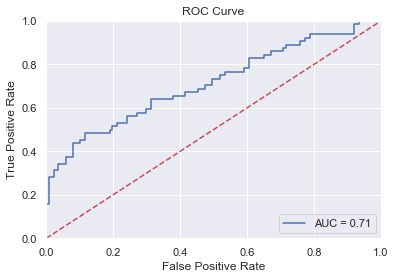

In [33]:
predictions = gs_knn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')
savefig('../images/knn/pca_val.png')

Balanced_Accuracy: 0.7112462006079028
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        47
           1       0.70      0.57      0.63        28

   micro avg       0.75      0.75      0.75        75
   macro avg       0.73      0.71      0.72        75
weighted avg       0.74      0.75      0.74        75



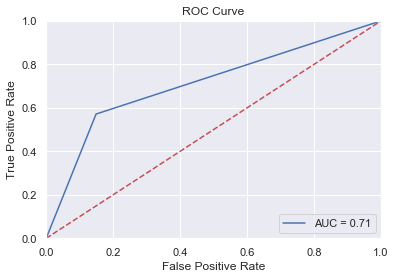

In [ ]:
predictions = gs_knn.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_knn, 'test')
savefig('../images/knn/pca_test.png')

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30, 40, 50]
criterion = ['gini']
max_depth = [10, 20, 30]
min_samples_leaf = [1,2,3,4]
min_samples_split = [1,2,3,4]

params_rf = {'n_estimators': num_trees, 'criterion': criterion, 'max_depth': max_depth}
gs_rf = GridSearchCV(rf, params_rf, cv=10)

gs_rf.fit(features_train, target_train)
gs_rf.best_estimator_

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Balanced_Accuracy: 0.7056911496350364
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       137
           1       0.76      0.48      0.59        64

   micro avg       0.79      0.79      0.79       201
   macro avg       0.77      0.71      0.72       201
weighted avg       0.78      0.79      0.77       201



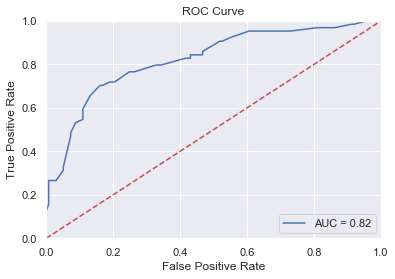

In [ ]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')
savefig('../images/rf/pca_val.png')

Balanced_Accuracy: 0.6466565349544073
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        47
           1       0.77      0.36      0.49        28

   micro avg       0.72      0.72      0.72        75
   macro avg       0.74      0.65      0.65        75
weighted avg       0.73      0.72      0.69        75



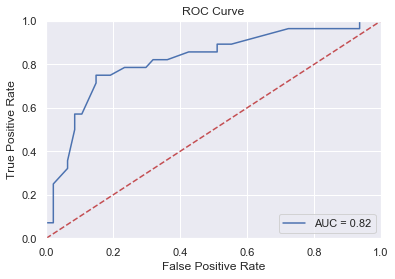

In [ ]:
predictions = gs_rf.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_rf, 'test')
savefig('../images/rf/pca_test.png')

### NN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

nn = MLPClassifier(activation='logistic')

hidden_layer_sizes = [50, 75, 100, 125, 150]
solver = ['lbfgs']
alpha = [1e-3, 1e-4, 1e-5]
tol = [1e-3, 1e-4, 1e-5]



params_nn = {'hidden_layer_sizes': hidden_layer_sizes, 'solver': solver, 'tol': tol}
gs_nn = GridSearchCV(nn, params_nn, cv=10)

gs_nn.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [50, 75, 100, 125, 150], 'solver': ['lbfgs'], 'tol': [0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.6884124087591241
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       137
           1       0.54      0.62      0.58        64

   micro avg       0.71      0.71      0.71       201
   macro avg       0.68      0.69      0.68       201
weighted avg       0.72      0.71      0.72       201



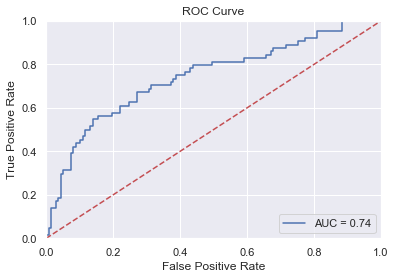

In [ ]:
predictions = gs_nn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_nn, 'val')
savefig('../images/nn/pca_val.png')

Balanced_Accuracy: 0.7860942249240122
              precision    recall  f1-score   support

           0       0.82      0.89      0.86        47
           1       0.79      0.68      0.73        28

   micro avg       0.81      0.81      0.81        75
   macro avg       0.81      0.79      0.79        75
weighted avg       0.81      0.81      0.81        75



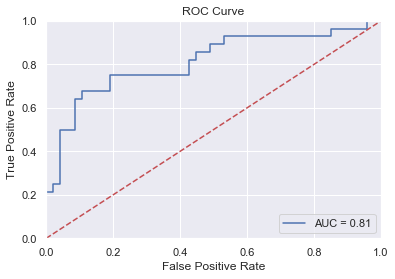

In [ ]:
predictions = gs_nn.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_nn, 'test')
savefig('../images/nn/pca_test.png')

### SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


svm = SVC(kernel = 'linear', probability=True)

costs = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gammas = [0.005,.015, 0.01,0.02,0.03,0.04,0.05]
params_svm = {'C': costs, 'gamma' : gammas}

gs_svm = GridSearchCV(svm, params_svm, cv=10)

gs_svm.fit(features_train, target_train)

In [ ]:
predictions = gs_svm.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_svm, 'val')
savefig('../images/svc/pca_val.png')

In [ ]:
predictions = gs_svm.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_svm, 'test')
savefig('../images/svc/pca_test.png')

### QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

tols = [1e-3, 1e-4, 1e-5]
params_qda = {'tol': tols}

gs_qda = GridSearchCV(qda, params_qda, cv=10)

gs_qda.fit(features_train, target_train)
predictions = gs_qda.predict(features_test)

In [ ]:
predictions = gs_qda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_qda, 'val')
savefig('../images/qda/pca_val.png')

In [ ]:
predictions = gs_qda.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_qda, 'test')
savefig('../images/qda/pca_test.png')